# Tarea 2 – MLOps

## Task 1: Predict Product Failures
## Task 2: Evaluate Data Drift

**Objetivo:**  
- **Task 1:** Usar los datos de `train.csv` para entrenar un modelo de clasificación que prediga si un producto fallará o no, y generar predicciones sobre `test.csv`.
- **Task 2:** Evaluar si existe *data drift* entre los conjuntos de entrenamiento y test, entrenando un modelo que intente distinguir si una muestra proviene de `train.csv` o `test.csv`.

---
## 0. Imports y Configuración

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Intentar importar xgboost / lightgbm si están disponibles
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
    print('XGBoost disponible ✓')
except ImportError:
    HAS_XGB = False
    print('XGBoost no disponible – se usará GradientBoosting de sklearn')

try:
    from lightgbm import LGBMClassifier
    HAS_LGB = True
    print('LightGBM disponible ✓')
except ImportError:
    HAS_LGB = False
    print('LightGBM no disponible')

SEED = 42
np.random.seed(SEED)

plt.rcParams.update({'figure.dpi': 110, 'figure.figsize': (10, 5)})
sns.set_style('whitegrid')

print('\nLibrerías cargadas correctamente.')

XGBoost disponible ✓
LightGBM disponible ✓

Librerías cargadas correctamente.


---
## 1. Carga y Exploración de Datos

In [2]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape:  {test.shape}')
display(train.head())

Train shape: (26570, 26)
Test shape:  (20775, 25)


,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [3]:
print('=== Tipos de datos (train) ===')
print(train.dtypes)
print()
print('=== Distribución del target (failure) ===')
print(train['failure'].value_counts())
print(f'\nTasa de fallos: {train["failure"].mean():.4f} ({train["failure"].mean()*100:.2f}%)')

=== Tipos de datos (train) ===
id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object

=== Distribución del target (failure) ===
failure
0    20921
1     5649
Name: count, dtype: int64

Tasa de fallos: 0.2126 (21.26%)


In [4]:
print('=== Valores nulos (train) ===')
null_train = train.isnull().sum()
print(null_train[null_train > 0])
print()
print('=== Valores nulos (test) ===')
null_test = test.isnull().sum()
print(null_test[null_test > 0])

=== Valores nulos (train) ===
loading            250
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
dtype: int64

=== Valores nulos (test) ===
loading            223
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64


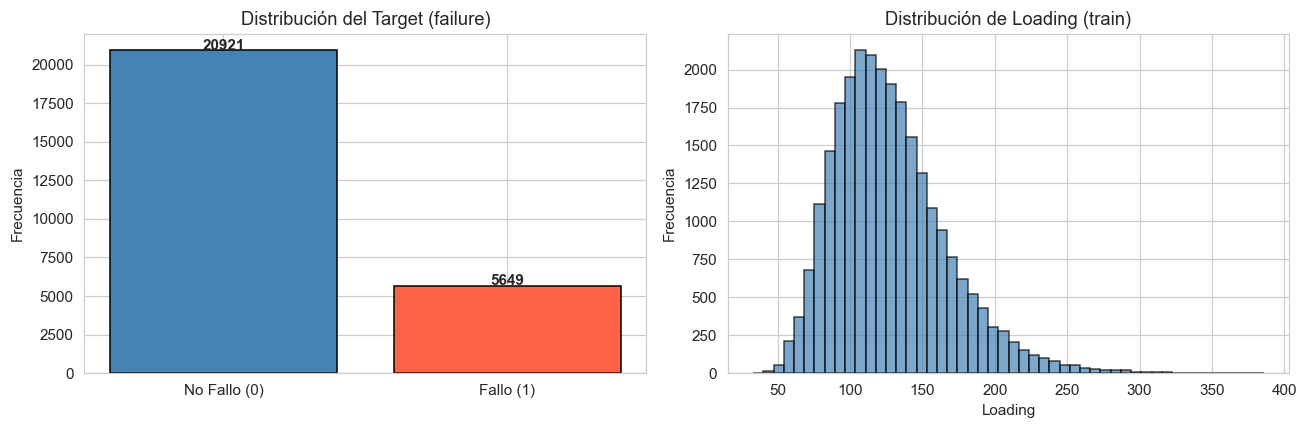

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribución del target
counts = train['failure'].value_counts()
axes[0].bar(['No Fallo (0)', 'Fallo (1)'], counts.values, color=['steelblue', 'tomato'], edgecolor='black')
axes[0].set_title('Distribución del Target (failure)')
axes[0].set_ylabel('Frecuencia')
for i, v in enumerate(counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Distribución de loading
axes[1].hist(train['loading'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribución de Loading (train)')
axes[1].set_xlabel('Loading')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

---
## 2. Preprocesamiento – Task 1

In [6]:
# Identificar columnas categóricas y numéricas
CAT_COLS  = [c for c in train.columns if train[c].dtype == 'object' and c not in ['id', 'product_code']]
NUM_COLS  = [c for c in train.columns if train[c].dtype != 'object' and c not in ['id', 'failure']]

print('Columnas categóricas:', CAT_COLS)
print('Columnas numéricas  :', NUM_COLS)

Columnas categóricas: ['attribute_0', 'attribute_1']
Columnas numéricas  : ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']


In [7]:
def preprocess(df_train, df_test):
    """Preprocesa train y test de forma conjunta (evita data leakage)."""
    train_proc = df_train.copy()
    test_proc  = df_test.copy()

    # Codificar columnas categóricas (LabelEncoder ajustado sobre train)
    le_dict = {}
    for col in CAT_COLS:
        le = LabelEncoder()
        combined = pd.concat([train_proc[col], test_proc[col]], axis=0).astype(str)
        le.fit(combined)
        train_proc[col] = le.transform(train_proc[col].astype(str))
        test_proc[col]  = le.transform(test_proc[col].astype(str))
        le_dict[col] = le

    # Codificar product_code
    le_pc = LabelEncoder()
    combined_pc = pd.concat([train_proc['product_code'], test_proc['product_code']], axis=0).astype(str)
    le_pc.fit(combined_pc)
    train_proc['product_code'] = le_pc.transform(train_proc['product_code'].astype(str))
    test_proc['product_code']  = le_pc.transform(test_proc['product_code'].astype(str))

    # Columnas de features (sin id ni failure)
    FEATURE_COLS = [c for c in train_proc.columns if c not in ['id', 'failure']]

    X_train = train_proc[FEATURE_COLS]
    y_train = train_proc['failure'].astype(int)
    X_test  = test_proc[FEATURE_COLS]

    return X_train, y_train, X_test, FEATURE_COLS


X_train, y_train, X_test, FEATURE_COLS = preprocess(train, test)
print(f'X_train: {X_train.shape}  |  X_test: {X_test.shape}')
print('Features:', FEATURE_COLS)

X_train: (26570, 24)  |  X_test: (20775, 24)
Features: ['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']


---
## 3. Entrenamiento del Modelo – Task 1

Se evalúan varios modelos mediante validación cruzada estratificada (5-fold)  
y se selecciona el de mejor **ROC-AUC**.

In [8]:
def make_pipeline(clf):
    """Crea un pipeline con imputación de medianas + clasificador."""
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('clf', clf)
    ])


# Definir candidatos
candidates = {
    'RandomForest': make_pipeline(
        RandomForestClassifier(n_estimators=300, max_depth=8, random_state=SEED, n_jobs=-1)
    ),
    'GradientBoosting': make_pipeline(
        GradientBoostingClassifier(n_estimators=200, max_depth=4, learning_rate=0.05, random_state=SEED)
    ),
    'LogisticRegression': make_pipeline(
        LogisticRegression(max_iter=1000, random_state=SEED, solver='lbfgs')
    ),
}

if HAS_XGB:
    candidates['XGBoost'] = make_pipeline(
        XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                      use_label_encoder=False, eval_metric='logloss',
                      random_state=SEED, n_jobs=-1)
    )

if HAS_LGB:
    candidates['LightGBM'] = make_pipeline(
        LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                       random_state=SEED, n_jobs=-1, verbose=-1)
    )


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
results = {}

for name, pipe in candidates.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                             scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f'{name:25s}  AUC = {scores.mean():.4f} ± {scores.std():.4f}')

print()
best_name = max(results, key=lambda k: results[k].mean())
print(f'>>> Mejor modelo: {best_name}  (AUC = {results[best_name].mean():.4f})')

RandomForest               AUC = 0.5824 ± 0.0046
GradientBoosting           AUC = 0.5771 ± 0.0063
LogisticRegression         AUC = 0.5874 ± 0.0079
XGBoost                    AUC = 0.5572 ± 0.0027
LightGBM                   AUC = 0.5590 ± 0.0067

>>> Mejor modelo: LogisticRegression  (AUC = 0.5874)


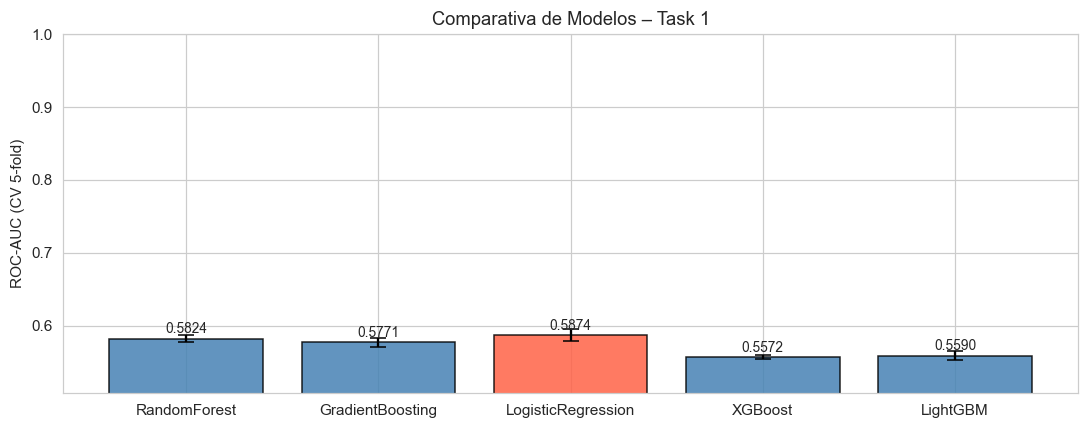

In [9]:
# Visualizar comparativo de modelos
fig, ax = plt.subplots(figsize=(10, 4))
names = list(results.keys())
means = [results[n].mean() for n in names]
stds  = [results[n].std()  for n in names]

colors = ['tomato' if n == best_name else 'steelblue' for n in names]
bars = ax.bar(names, means, yerr=stds, capsize=5, color=colors, edgecolor='black', alpha=0.85)
ax.set_ylim(min(means) - 0.05, 1.0)
ax.set_ylabel('ROC-AUC (CV 5-fold)')
ax.set_title('Comparativa de Modelos – Task 1')
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
            f'{mean:.4f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

---
## 4. Entrenamiento Final y Generación de Predicciones – Task 1

AUC sobre train (referencia): 0.5929


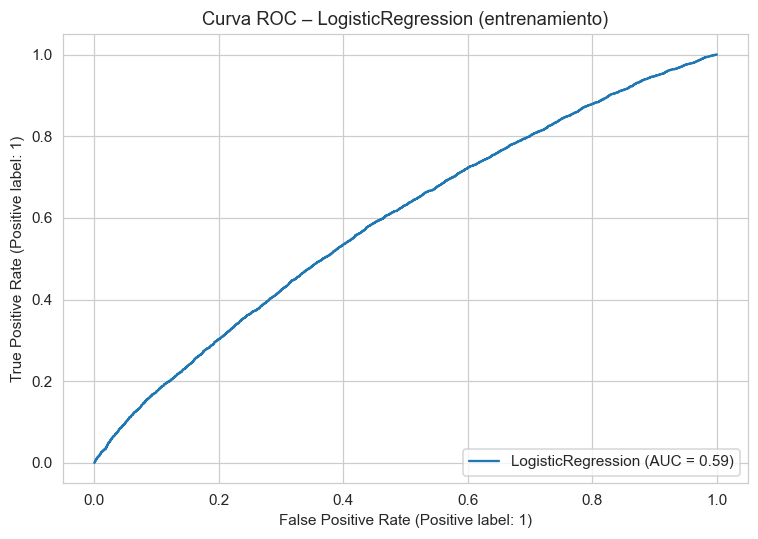

In [10]:
best_pipe = candidates[best_name]
best_pipe.fit(X_train, y_train)

# Predicciones de probabilidad sobre test
y_pred_proba = best_pipe.predict_proba(X_test)[:, 1]

# Curva ROC sobre train (referencia interna)
y_train_proba = best_pipe.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)
print(f'AUC sobre train (referencia): {train_auc:.4f}')

fig, ax = plt.subplots(figsize=(7, 5))
RocCurveDisplay.from_predictions(y_train, y_train_proba, ax=ax, name=best_name)
ax.set_title(f'Curva ROC – {best_name} (entrenamiento)')
plt.tight_layout()
plt.show()

Umbral óptimo (F1 máximo en train): 0.1869

=== Reporte de clasificación (train, umbral óptimo) ===
              precision    recall  f1-score   support

    No Fallo       0.84      0.40      0.54     20921
       Fallo       0.25      0.73      0.37      5649

    accuracy                           0.47     26570
   macro avg       0.54      0.56      0.45     26570
weighted avg       0.72      0.47      0.50     26570



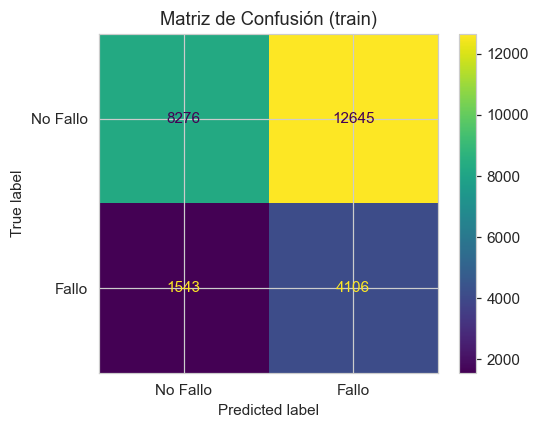

In [12]:
# Umbral óptimo sobre train
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-9)
best_thresh = thresholds[np.argmax(f1_scores[:-1])]
print(f'Umbral óptimo (F1 máximo en train): {best_thresh:.4f}')

y_train_pred = (y_train_proba >= best_thresh).astype(int)
print()
print('=== Reporte de clasificación (train, umbral óptimo) ===')
print(classification_report(y_train, y_train_pred, target_names=['No Fallo', 'Fallo']))

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        display_labels=['No Fallo', 'Fallo'], ax=ax)
ax.set_title('Matriz de Confusión (train)')
plt.tight_layout()
plt.show()

In [20]:
# Guardar submission
submission = pd.DataFrame({
    'id': test['id'],
    'failure': y_pred_proba
})
submission.to_csv('submission_definitivo.csv', index=False)
print('Archivo submission_definitivo.csv guardado.')
display(submission.head(10))

Archivo submission_definitivo.csv guardado.


,id,failure
0,26570,0.233037
1,26571,0.173274
2,26572,0.213606
3,26573,0.218108
4,26574,0.372758
5,26575,0.181506
6,26576,0.193728
7,26577,0.253616
8,26578,0.154239
9,26579,0.194538


---
## 5. Task 2 – Evaluación de Data Drift

### Concepto

El **data drift** ocurre cuando la distribución estadística de los datos de producción  
(en este caso `test.csv`) difiere significativamente de la distribución de entrenamiento  
(`train.csv`). Esto puede degradar el rendimiento del modelo en producción.

### Metodología

1. Combinar `train.csv` y `test.csv` (sin la columna `failure` ni `id`).
2. Añadir una nueva columna **target** (`0` = proviene de train, `1` = proviene de test).
3. Entrenar un clasificador para distinguir de qué conjunto proviene cada muestra.
4. Interpretar el **AUC** del clasificador:
   - **AUC ≈ 0.5** → el modelo no puede distinguir entre train y test → **sin data drift**.
   - **AUC >> 0.5** (p.ej. > 0.6-0.7) → el modelo distingue fácilmente → **hay data drift**.

In [13]:
# --- Preparar el dataset combinado ---
train_drift = train.drop(columns=['failure', 'id'], errors='ignore').copy()
test_drift  = test.drop(columns=['id'], errors='ignore').copy()

train_drift['drift_target'] = 0  # 0 = viene de train
test_drift['drift_target']  = 1  # 1 = viene de test

combined = pd.concat([train_drift, test_drift], axis=0, ignore_index=True)
combined = combined.sample(frac=1, random_state=SEED).reset_index(drop=True)  # shuffle

print(f'Dataset combinado: {combined.shape}')
print(combined['drift_target'].value_counts())
display(combined.head())

Dataset combinado: (47345, 25)
drift_target
0    26570
1    20775
Name: count, dtype: int64


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,drift_target
0,C,152.84,material_7,material_8,5,8,5,8,5,17.404,...,11.439,18.752,20.504,11.753,16.821,13.705,17.886,19.640,694.593,0
1,D,178.97,material_7,material_5,6,6,12,14,13,16.757,...,11.908,16.736,20.114,9.691,NaN,16.252,NaN,NaN,654.035,0
2,A,127.50,material_7,material_8,9,5,9,6,4,17.356,...,11.452,16.372,19.585,12.166,15.200,14.723,14.108,15.903,429.748,0
3,A,123.55,material_7,material_8,9,5,10,6,3,16.813,...,10.994,17.891,19.225,12.195,16.315,15.900,14.979,16.677,772.677,0
4,I,101.02,material_7,material_5,9,5,2,7,5,17.431,...,11.643,16.442,17.321,13.406,15.009,16.787,13.932,14.762,778.600,1


In [14]:
# --- Preprocesar el dataset combinado ---
CAT_COLS_DRIFT = [c for c in combined.columns
                  if combined[c].dtype == 'object' and c != 'drift_target']

combined_proc = combined.copy()
for col in CAT_COLS_DRIFT:
    le = LabelEncoder()
    combined_proc[col] = le.fit_transform(combined_proc[col].astype(str))

X_drift = combined_proc.drop(columns=['drift_target'])
y_drift = combined_proc['drift_target']

print(f'X_drift: {X_drift.shape}  |  y_drift distribución: {y_drift.value_counts().to_dict()}')

X_drift: (47345, 24)  |  y_drift distribución: {0: 26570, 1: 20775}


In [15]:
# --- Entrenar clasificador de drift con validación cruzada ---
drift_clf = make_pipeline(
    RandomForestClassifier(n_estimators=200, max_depth=6, random_state=SEED, n_jobs=-1)
)

cv_drift = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
drift_scores = cross_val_score(drift_clf, X_drift, y_drift,
                               cv=cv_drift, scoring='roc_auc', n_jobs=-1)

drift_auc_mean = drift_scores.mean()
drift_auc_std  = drift_scores.std()

print(f'AUC del clasificador de drift: {drift_auc_mean:.4f} ± {drift_auc_std:.4f}')
print()

if drift_auc_mean < 0.55:
    verdict = '✅ Sin data drift detectado: los datasets son estadísticamente homogéneos.'
elif drift_auc_mean < 0.65:
    verdict = '⚠️ Data drift leve: existe alguna diferencia distribucional, pero moderada.'
else:
    verdict = '🚨 Data drift significativo: el modelo puede distinguir fácilmente entre train y test.'

print(f'Veredicto: {verdict}')

AUC del clasificador de drift: 1.0000 ± 0.0000

Veredicto: 🚨 Data drift significativo: el modelo puede distinguir fácilmente entre train y test.


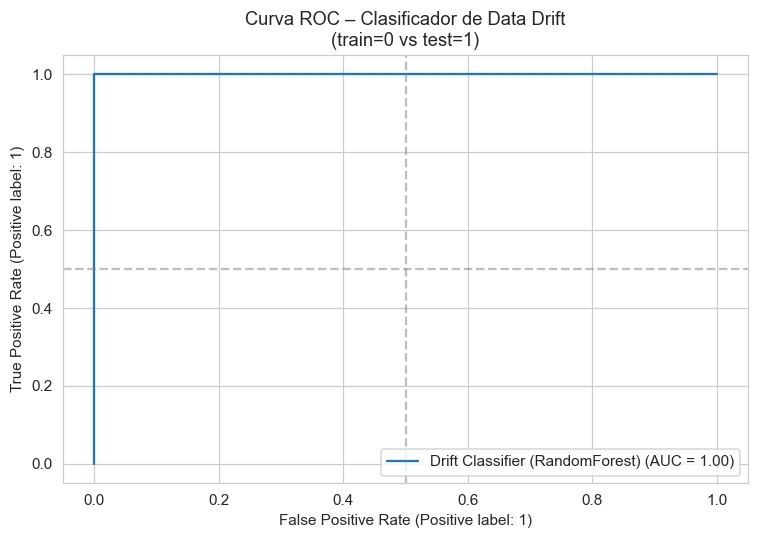

In [16]:
# --- Curva ROC del clasificador de drift ---
from sklearn.model_selection import cross_val_predict

y_drift_proba = cross_val_predict(drift_clf, X_drift, y_drift,
                                   cv=cv_drift, method='predict_proba', n_jobs=-1)[:, 1]

fig, ax = plt.subplots(figsize=(7, 5))
RocCurveDisplay.from_predictions(y_drift, y_drift_proba, ax=ax,
                                  name='Drift Classifier (RandomForest)')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Curva ROC – Clasificador de Data Drift\n(train=0 vs test=1)')
plt.tight_layout()
plt.show()

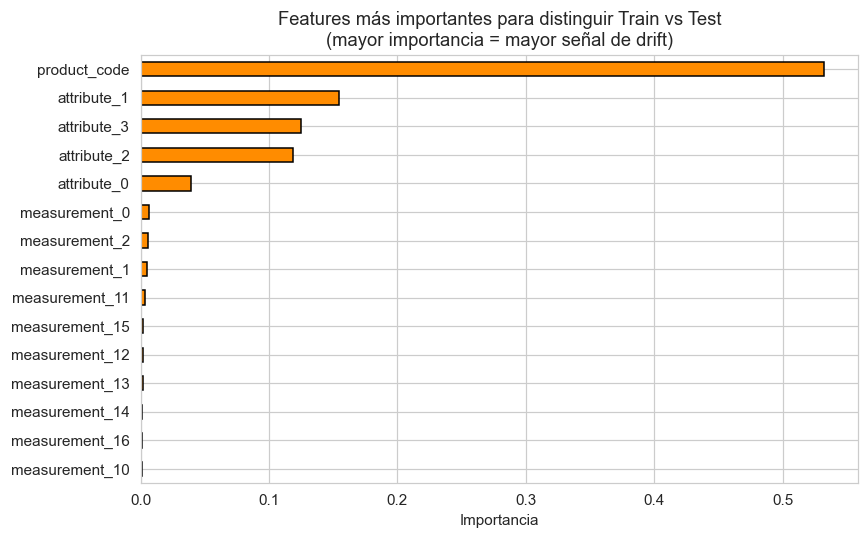

In [17]:
# --- Importancia de features del clasificador de drift ---
drift_clf_fitted = drift_clf.fit(X_drift, y_drift)
importances_drift = pd.Series(
    drift_clf_fitted.named_steps['clf'].feature_importances_,
    index=X_drift.columns
).nlargest(15)

fig, ax = plt.subplots(figsize=(8, 5))
importances_drift.sort_values().plot.barh(ax=ax, color='darkorange', edgecolor='black')
ax.set_title('Features más importantes para distinguir Train vs Test\n(mayor importancia = mayor señal de drift)')
ax.set_xlabel('Importancia')
plt.tight_layout()
plt.show()

---
## 6. Análisis Visual de Distribuciones (Comprobación de Drift)

Inspeccionamos visualmente las distribuciones de las **features más importantes** del clasificador de drift  
para entender dónde hay diferencias entre train y test.

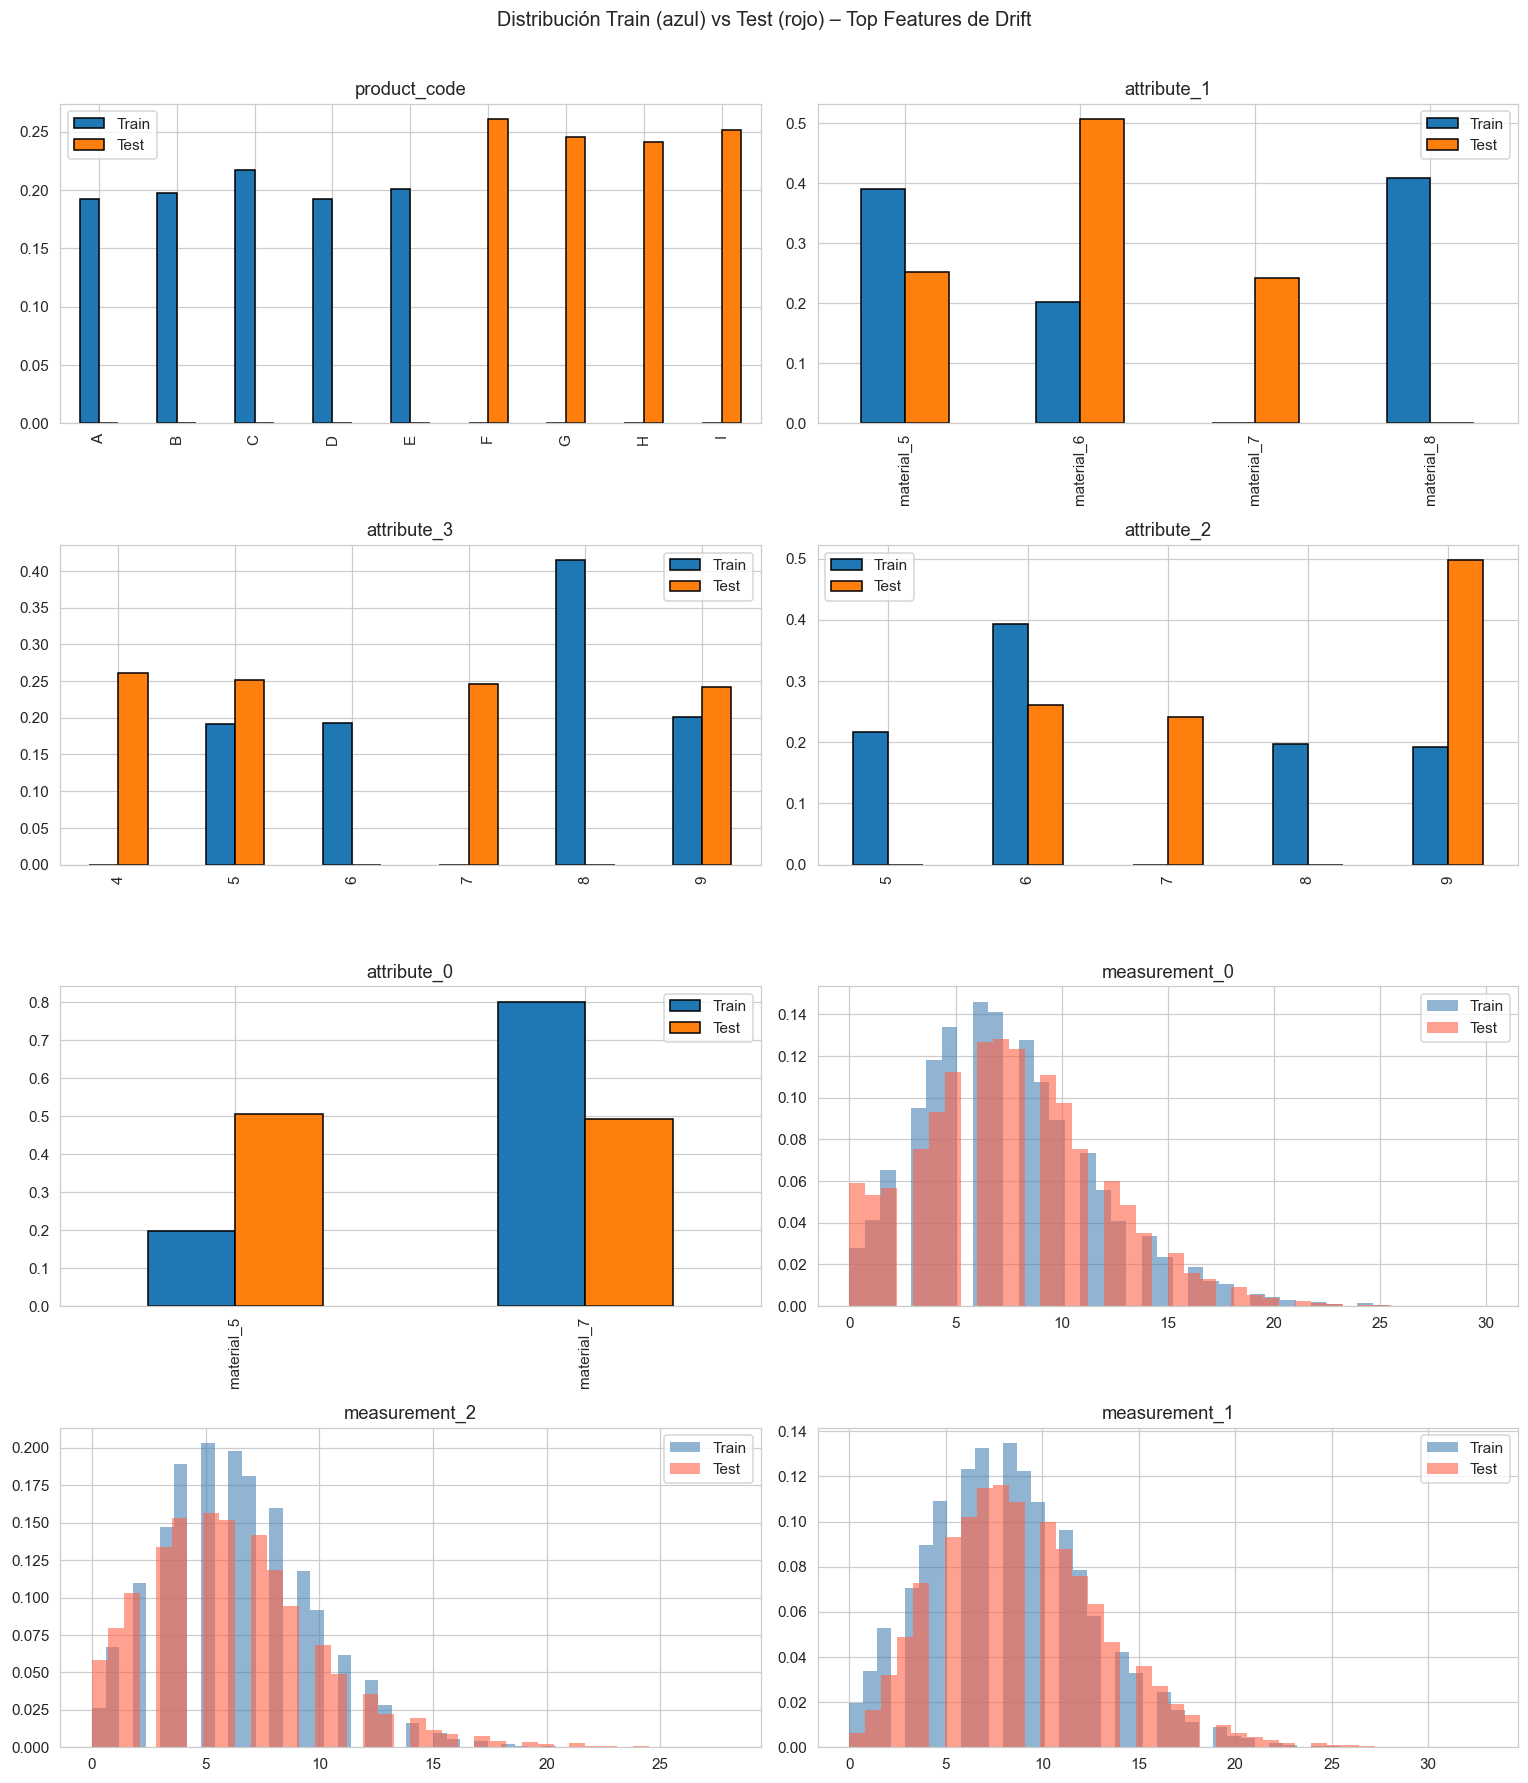

In [18]:
top_drift_features = importances_drift.index.tolist()[:8]

n_cols = 2
n_rows = int(np.ceil(len(top_drift_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

train_ref = train.drop(columns=['failure', 'id'], errors='ignore').copy()
test_ref  = test.drop(columns=['id'], errors='ignore').copy()

for i, feat in enumerate(top_drift_features):
    ax = axes[i]
    if feat in train_ref.columns and feat in test_ref.columns:
        tr_vals = train_ref[feat].dropna()
        te_vals = test_ref[feat].dropna()

        if tr_vals.dtype == 'object' or tr_vals.nunique() <= 10:
            # Variable categórica o discreta
            pd.DataFrame({'Train': tr_vals.value_counts(normalize=True),
                          'Test' : te_vals.value_counts(normalize=True)}).plot.bar(ax=ax, edgecolor='black')
            ax.set_title(f'{feat}')
            ax.set_xlabel('')
        else:
            # Variable numérica continua
            ax.hist(tr_vals, bins=40, alpha=0.6, label='Train', density=True, color='steelblue', edgecolor='none')
            ax.hist(te_vals, bins=40, alpha=0.6, label='Test',  density=True, color='tomato',    edgecolor='none')
            ax.set_title(f'{feat}')
            ax.legend()
    else:
        ax.set_visible(False)

# Ocultar ejes sobrantes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Distribución Train (azul) vs Test (rojo) – Top Features de Drift', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

---
## 7. Interpretación y Conclusiones

### Task 1 – Predicción de Fallos

- Se evaluaron varios clasificadores mediante validación cruzada estratificada 5-fold.
- El modelo seleccionado es el de mayor AUC y se usó para generar las predicciones en `submission_definitivo.csv`.
- Se incluyó análisis de importancia de features y se calculó el umbral óptimo de clasificación.

---

### Task 2 – Data Drift

> **¿Cómo se comportaría el modelo si hay data drift?**  
> Si existe data drift, el clasificador de drift (que intenta predecir si la muestra proviene de train o test)  
> obtendrá un **AUC significativamente mayor que 0.5**, lo que significa que las distribuciones son **distinguibles**.
> Esto implica que el modelo de Task 1 entrenado con los datos de train puede degradar su rendimiento  
> al aplicarse sobre test, ya que se enfrentará a una distribución diferente a la que fue entrenado.

> **¿Y en el caso contrario (sin data drift)?**  
> Si NO hay data drift, el clasificador de drift obtiene un **AUC próximo a 0.5**, lo que indica que  
> las muestras de train y test son **indistinguibles estadísticamente**.  
> Esto garantiza que el modelo entrenado seguirá siendo válido y relevante para los datos de test,  
> y las métricas de validación cruzada serán una buena estimación del rendimiento real en producción.

**Regla práctica:**

| AUC del clasificador de drift | Interpretación |
|-------------------------------|----------------|
| ~0.50                         | Sin drift – datasets homogéneos ✅ |
| 0.55 – 0.65                   | Drift leve – monitorizar ⚠️ |
| > 0.65                        | Drift significativo – reentrenar 🚨 |

In [19]:
print('=' * 60)
print('              RESUMEN FINAL')
print('=' * 60)
print(f'Task 1 – Mejor modelo       : {best_name}')
print(f'Task 1 – AUC (CV 5-fold)    : {results[best_name].mean():.4f} ± {results[best_name].std():.4f}')
print(f'Task 1 – Submission         : submission_definitivo.csv')
print()
print(f'Task 2 – AUC Drift Classifier: {drift_auc_mean:.4f} ± {drift_auc_std:.4f}')
print(f'Task 2 – Veredicto          : {verdict}')
print('=' * 60)

              RESUMEN FINAL
Task 1 – Mejor modelo       : LogisticRegression
Task 1 – AUC (CV 5-fold)    : 0.5874 ± 0.0079
Task 1 – Submission         : submission_definitivo.csv

Task 2 – AUC Drift Classifier: 1.0000 ± 0.0000
Task 2 – Veredicto          : 🚨 Data drift significativo: el modelo puede distinguir fácilmente entre train y test.
